In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns
import cartopy as cart
from geopy.distance import geodesic


# TODO: reassign functions to their new locations once notebooks and dev-dataloading merge
import gtc_functions
# TODO: clean up notebook

In [3]:
# TODO: better common path solution. Lisanne's use of Owen's functions? Cambridge-hosted data server?
google_drive_personal_key = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/'

In [4]:
### LOAD IN RELEVANT DFS
# /Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/xBD_data/xbd_points_posthurr_reformatted.pkl
# xbd observation points
df_xbd_points_path = google_drive_personal_key + 'datasets/xBD_data/xbd_points_posthurr_reformatted.pkl'
df_xbd_points = pd.read_pickle(df_xbd_points_path)
# noaa 6-hourly
df_noaa_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/noaa_hurricanes.pkl'
df_noaa_weather = pd.read_pickle(df_noaa_pkl_path)
# weather stations
df_stations_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/weather_stations.pkl'
df_stations = pd.read_pickle(df_stations_pkl_path)
# noaa six-hourly closest to each xbd point
df_noaa_xbd_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/xbd_obs_noaa_six_hourly.pkl'
df_noaa_xbd_weather = pd.read_pickle(df_noaa_xbd_pkl_path)
# weather stations info for each xbd point
df_stations_xbd_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/xbd_stations_info.pkl'
df_stations_xbd = pd.read_pickle(df_stations_xbd_pkl_path)


# Visualise hurricane data

### Strength and frequency of hurricane events in US

In [5]:
# historic trend of hurricane events (for powerpoint)

# group df by tag and get maximum strength for each 
max_strength_by_tag = df_noaa_weather.groupby(by='tag')['strength'].max()
# create new dataframe containing only max event strength and event_start date for each tag
df_event_max_strengths = pd.DataFrame({
    'date': df_noaa_weather.groupby(by='tag')['date'].min(),
    'strength': max_strength_by_tag})
# exclude rows with maximum strength as 0 (not a hurricane)
df_event_max_strengths = df_event_max_strengths[df_event_max_strengths['strength'] != 0]

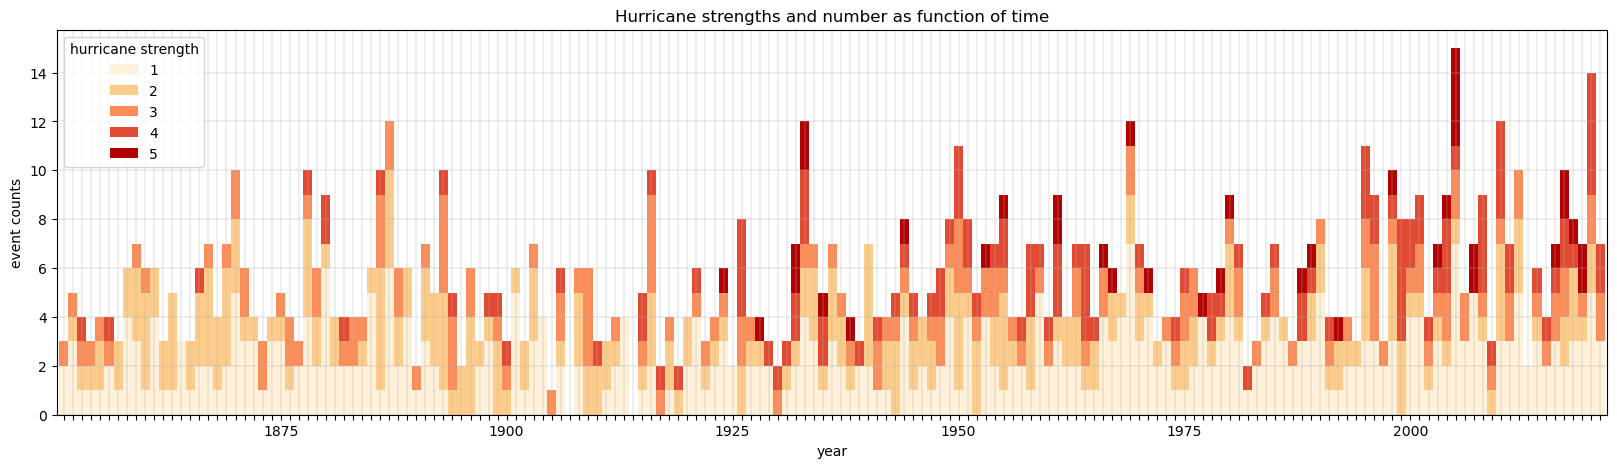

In [6]:
fig,ax = plt.subplots(figsize=[20,5])

# group the data by year and strength, and count the number of events
grouped = df_event_max_strengths.groupby([df_event_max_strengths['date'].dt.year, 'strength']).size().reset_index(name='count')
# pivot the data to create a stacked bar chart
pivot = grouped.pivot(index='date', columns='strength', values='count')

# fill in missing years with rows of nans
years = pd.DataFrame(index=range(pivot.index.min(), pivot.index.max()+1))
full_years = years.merge(pivot, left_index=True, right_index=True, how='outer')
# colour palette
five_colours = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']

full_years.plot(ax=ax, kind='bar', stacked=True, color=five_colours, width=1)

# formatting
ax.set_title('Hurricane strengths and number as function of time')
ax.set_xlabel('year')
ax.set_ylabel('event counts')
# hide all but 25th year – needed to adjust to account for starting at 1851
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if (i+1) % 25 != 0]
ax.legend(title='hurricane strength');
plt.xticks(rotation=0)
ax.grid(which='major',linewidth=0.3)

### Event duration and track length as function of time

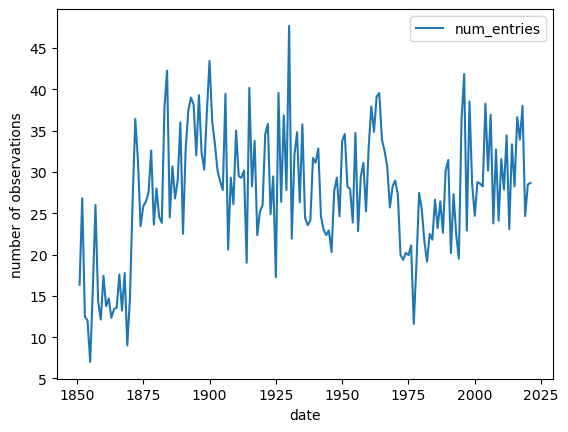

In [7]:
# TL;DR plotting by mean number of entries per year shows no trend
tag_counts = df_noaa_weather.groupby([df_noaa_weather['date'].dt.year, 'tag'])['num_entries'].mean()
tag_counts = pd.DataFrame(tag_counts)
year_count_mean = tag_counts.groupby('date').mean()
year_count_mean.plot()
plt.ylabel('number of observations');

There is no discernable trend in the mean number of observations (time for which event continues) for hurricane events over time

In [29]:
# calculate distance covered by hurricane

def calculate_distances_between_group_rows(
	group: pd.core.groupby.DataFrameGroupBy,
) -> pd.core.groupby.DataFrameGroupBy:
	group['distance_between_observations'] = [np.nan] + [
			geodesic((group.iloc[i].lat, group.iloc[i].lon), (group.iloc[i+1].lat, group.iloc[i+1].lon)).km 
			for i in range(len(group)-1)
			]
	return group

def calculate_distances_between_rows(
	df: pd.DataFrame
) -> pd.DataFrame:
	return df_noaa_weather.groupby('tag').apply(calculate_distances_between_group_rows).reset_index(drop=True)


def calculate_average_speed_between_rows(
	df: pd.DataFrame,
	distance_col_name: str = 'distance_between_observations'
) -> pd.DataFrame:
	"""Divide the distance travelled between six-hourly observations by 6 to return the average speed between
	observations in km/h.
	"""
	df['average_trajectory_speed'] = df[distance_col_name].divide(6)
	return df


In [38]:
df_noaa_distances = calculate_distances_between_rows(df_noaa_weather)
df_noaa_distances_speeds = calculate_average_speed_between_rows(df_noaa_distances)

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_60382/3079292091.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return df_noaa_weather.groupby('tag').apply(calculate_distances_between_group_rows).reset_index(drop=True)


Text(0, 0.5, 'mean speed of hurricane between six-hourly observations')

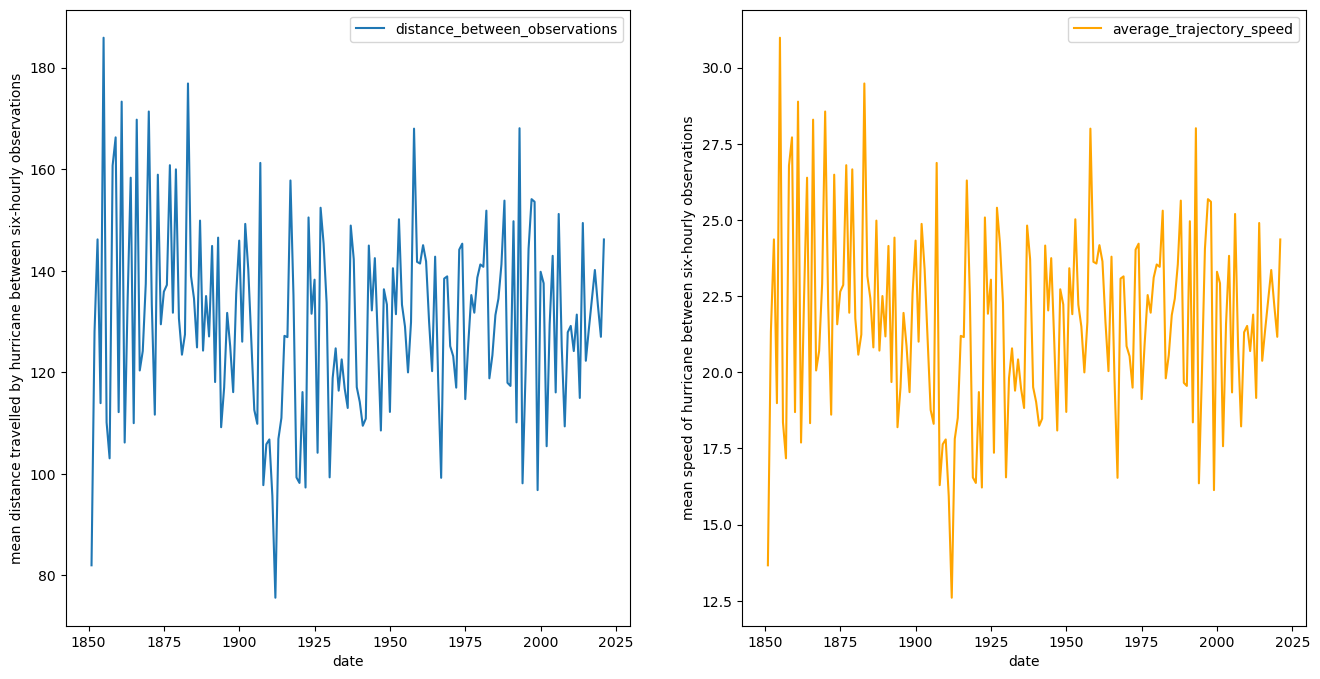

In [49]:
df_grouped_by_year_and_tag = df_noaa_distances.groupby([df_noaa_weather['date'].dt.year, 'tag'])

df_distances_by_tag = pd.DataFrame(df_grouped_by_year_and_tag['distance_between_observations'].mean())
df_speeds_by_tag = pd.DataFrame(df_grouped_by_year_and_tag['average_trajectory_speed'].mean())

mean_annual_distances = df_distances_by_tag.groupby('date').mean()
mean_annual_speed = df_speeds_by_tag.groupby('date').mean()

fix, ax = plt.subplots(1, 2, figsize=[16,8])
mean_annual_distances.plot(ax=ax[0])
mean_annual_speed.plot(ax=ax[1], color='orange')

# formatting
ax[0].set_ylabel('mean distance travelled by hurricane between six-hourly observations')
ax[1].set_ylabel('mean speed of hurricane between six-hourly observations')

### Economic and social impact of hurricanes in the US

From [NOAA Billion-Dollar Weather and Climate Disasters](https://www.ncei.noaa.gov/access/billions/events).

In [ ]:
### Processing damage data. Probably not worth scripting since not used elsewhere.

damage_file = google_drive_personal_key + 'datasets/EFs/weather_data/hurricane_damages/events-US-1980-2022.csv'
# load damage file (cost and fatalities per event)
df_damage_data = pd.read_csv(damage_file,skiprows=[0])
# standardise
df_damage_data_proc = gtc_functions.standardise_dfs(df_damage_data)
# remove any events which aren't hurricanes (also helps with following isolation of names, since event descriptors now
# same length)
df_damage_data_proc = df_damage_data[df_damage_data_proc['disaster_name'].str.contains('Hurricane')]
# remove non-name info from 'name' column and make upper case
# TODO: stop setting on copies of df slices
df_damage_data_proc['disaster_name'] = df_damage_data_proc['disaster_name'].apply(lambda x: x.split()[1].upper())
# format date columns to dt objects
df_damage_data_proc['begin_date'] = pd.to_datetime(df_damage_data_proc['begin_date'], format='%Y%m%d')
df_damage_data_proc['end_date'] = pd.to_datetime(df_damage_data_proc['end_date'], format='%Y%m%d')

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_51315/2548212394.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_damage_data_proc['disaster_name'] = df_damage_data_proc['disaster_name'].apply(lambda x: x.split()[1].upper())
/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_51315/2548212394.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_damage_data_proc['begin_date'] = pd.to_datetime(df_damage_data_proc['begin_date'], format='%Y%m%d')
/var/folders/07/lkvjp1kd47578txv8q6wy

In [ ]:
# limit df to only row for each event corresponding to the maximum event strength
df_max_strengths = df_noaa_weather.loc[df_noaa_weather.groupby('tag')['strength'].idxmax()]

# limit noaa weather to include only those hurricanes (by name) which occurred after 1980 for quicker merging
df_lim_eighties_hurricanes = df_max_strengths[
	(df_max_strengths['date'] >= pd.Timestamp('1980')) & (df_max_strengths['strength'] > 0)
	].drop_duplicates(subset='tag',keep='first')

In [ ]:
# match events based on name and date N.B. matching noaa df to damages df since noaa larger
# limit noaa df to those with same name as damage data
df_comb_prep = df_lim_eighties_hurricanes[df_lim_eighties_hurricanes['name'].apply(
	lambda x: np.any(np.in1d(x, df_damage_data_proc['disaster_name'].tolist())))] # no strength nans

# set start time as indexes
df_comb_prep.set_index('date', inplace=True)
df_damage_data_proc_comb = df_damage_data_proc.copy()
df_damage_data_proc_comb.set_index('begin_date', inplace=True)

# set tolerance of event start date
tol = pd.Timedelta(30, 'd')
df_merged = pd.merge_asof(
	left=df_damage_data_proc_comb, right=df_comb_prep.sort_values('date'), right_index=True, left_index=True, 
	direction='nearest', tolerance=tol)

df_merged.reset_index(inplace=True)
df_merged.head()

,begin_date,disaster_name,disaster,end_date,total_cpi-adjusted_cost_(millions_of_dollars),deaths,tag,name,num_entries,record_id,...,r_se_50,r_nw_50,r_sw_50,r_ne_64,r_se_64,r_nw_64,r_sw_64,r_max_wind,strength,geometry
0,1980-08-07,ALLEN,Tropical Cyclone,1980-08-11,2106.4,13,AL041980,ALLEN,46.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,POINT (-66.7 14.8)
1,1983-08-17,ALICIA,Tropical Cyclone,1983-08-20,8910.0,21,AL031983,ALICIA,25.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,POINT (-95 28.9)
2,1985-08-30,ELENA,Tropical Cyclone,1985-09-03,3580.9,4,AL051985,ELENA,33.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,POINT (-83.9 28.6)
3,1985-09-26,GLORIA,Tropical Cyclone,1985-09-28,2354.4,11,AL091985,GLORIA,65.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,POINT (-70 24.2)
4,1985-10-27,JUAN,Tropical Cyclone,1985-10-31,4100.9,63,AL121985,JUAN,29.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,POINT (-91.2 27.8)


In [ ]:
# group by event year and event strength and sum the damage amount
grouped = df_merged.groupby([df_merged['begin_date'].dt.year, 'strength']).sum(numeric_only=True).reset_index()
# pivot the table so that event strength is the column and event year is the index
pivoted_deaths = grouped.pivot(index='begin_date', columns='strength', values='deaths')
pivoted_cost = grouped.pivot(index='begin_date', columns='strength', values='total_cpi-adjusted_cost_(millions_of_dollars)')

# fill in missing years with rows of nans
years = pd.DataFrame(index=range(pivoted_cost.index.min(), pivoted_cost.index.max()+1))
full_years_deaths = years.merge(pivoted_deaths, left_index=True, right_index=True, how='outer')
full_years_cost = years.merge(pivoted_cost, left_index=True, right_index=True, how='outer')

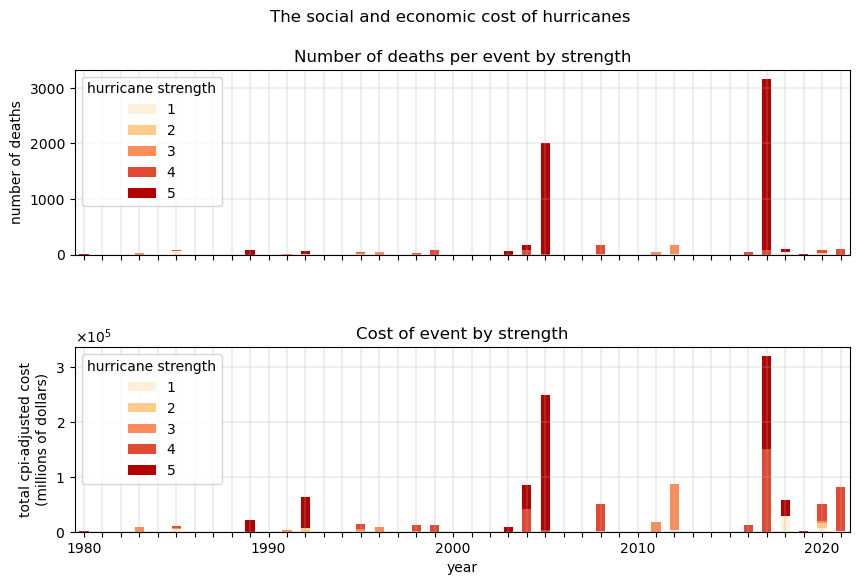

In [ ]:
fig, (ax_deaths,ax_cost) = plt.subplots(2, 1, figsize=[10,25], sharex=True)

# plot stacked bar chart
full_years_deaths.plot(ax=ax_deaths, kind='bar', stacked=True, figsize=(10,6), color=five_colours)
full_years_cost.plot(ax=ax_cost, kind='bar', stacked=True, figsize=(10,6), color=five_colours)

# format deaths axis
ax_deaths.set_ylabel('number of deaths')
ax_deaths.set_title('Number of deaths per event by strength')

# format cost axis
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,2))
ax_cost.yaxis.set_major_formatter(formatter)
ax_cost.set_ylabel('total cpi-adjusted cost\n(millions of dollars)')
ax_cost.set_title('Cost of event by strength')

for ax in (ax_deaths,ax_cost):
    ax.legend(title='hurricane strength')
    ax.grid(which='major',linewidth=0.3)

# format both axes
# show only every 10th label
[l.set_visible(False) for (i,l) in enumerate(ax_cost.xaxis.get_ticklabels()) if i % 10 != 0]

ax_cost.set_xlabel('year')
plt.xticks(rotation=0)
plt.suptitle('The social and economic cost of hurricanes');
fig.subplots_adjust(hspace=0.5)

N.B. these look very correlated...  Could be useful to consider whether deaths are a pattern of the country (plot by event) – but probably too small to see in a sample of four events.

In [ ]:
df_merged_no_nans = df_merged[df_merged['strength'].notna()]
df_merged_no_nans['strength'] = df_merged_no_nans['strength'].astype('category')

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_51315/1202840300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_no_nans['strength'] = df_merged_no_nans['strength'].astype('category')


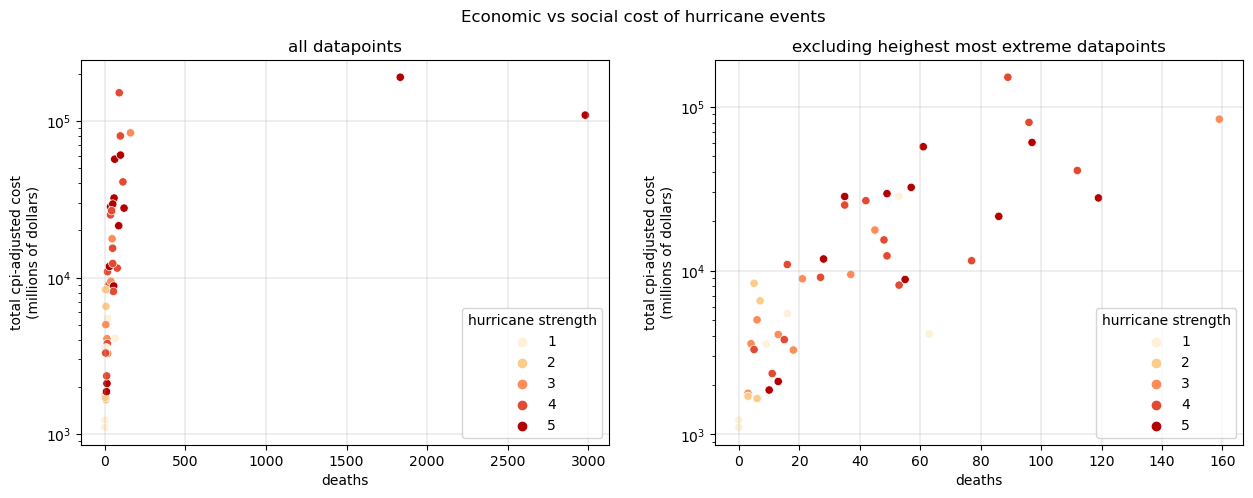

In [ ]:
fig, (ax_all, ax_lim) = plt.subplots(1, 2, figsize=[15,5])

strength_colour_map = {1: '#fef0d9', 2: '#fdcc8a', 3: '#fc8d59', 4: '#e34a33', 5: '#b30000'}

sns.scatterplot(ax=ax_all, 
    data=df_merged_no_nans[['deaths', 'total_cpi-adjusted_cost_(millions_of_dollars)','strength']], 
    x='deaths', y='total_cpi-adjusted_cost_(millions_of_dollars)', hue='strength', palette=strength_colour_map)

df_merged_no_nans_lim = df_merged_no_nans[df_merged_no_nans['deaths']<1500]
sns.scatterplot(ax=ax_lim, 
    data=df_merged_no_nans_lim[['deaths', 'total_cpi-adjusted_cost_(millions_of_dollars)','strength']], 
    x='deaths', y='total_cpi-adjusted_cost_(millions_of_dollars)', hue='strength', palette=strength_colour_map)

# formatting
for ax in (ax_all, ax_lim):
    ax.set_yscale('log')
    ax.set_ylabel('total cpi-adjusted cost\n(millions of dollars)')
    ax.grid(which='major',linewidth=0.3)
    ax.legend(title='hurricane strength', loc='lower right')

fig.suptitle('Economic vs social cost of hurricane events');
ax_all.set_title('all datapoints')
ax_lim.set_title('excluding heighest most extreme datapoints');

## Visualise hurricane tracks for xBD events

In [ ]:
# restrict hurricanes df to xbd events
xbd_hurricane_names = ['MICHAEL','MATTHEW','FLORENCE','HARVEY']
df_xbd_hurricanes_noaa = gtc_functions.return_most_recent_events_by_name(df_noaa_weather,xbd_hurricane_names)

# number of 6-hour intervals spanning xbd hurricanes in the Atlantic
num_6s = len(df_xbd_hurricanes_noaa)
print('number of 6-hour intervals spanning xbd hurricanes in the Atlantic: ', num_6s)
# number of 1-hour intervals spanning hurricanes in the Atlantic
# approximate since coarse (may have a couple of hours of weather caused the same
# storm on either end)
num_hourly = num_6s * 6
print('approximate number of 1-hour intervals spanning xbd hurricanes in the Atlantic: ', num_hourly)

number of 6-hour intervals spanning xbd hurricanes in the Atlantic:  241
approximate number of 1-hour intervals spanning xbd hurricanes in the Atlantic:  1446


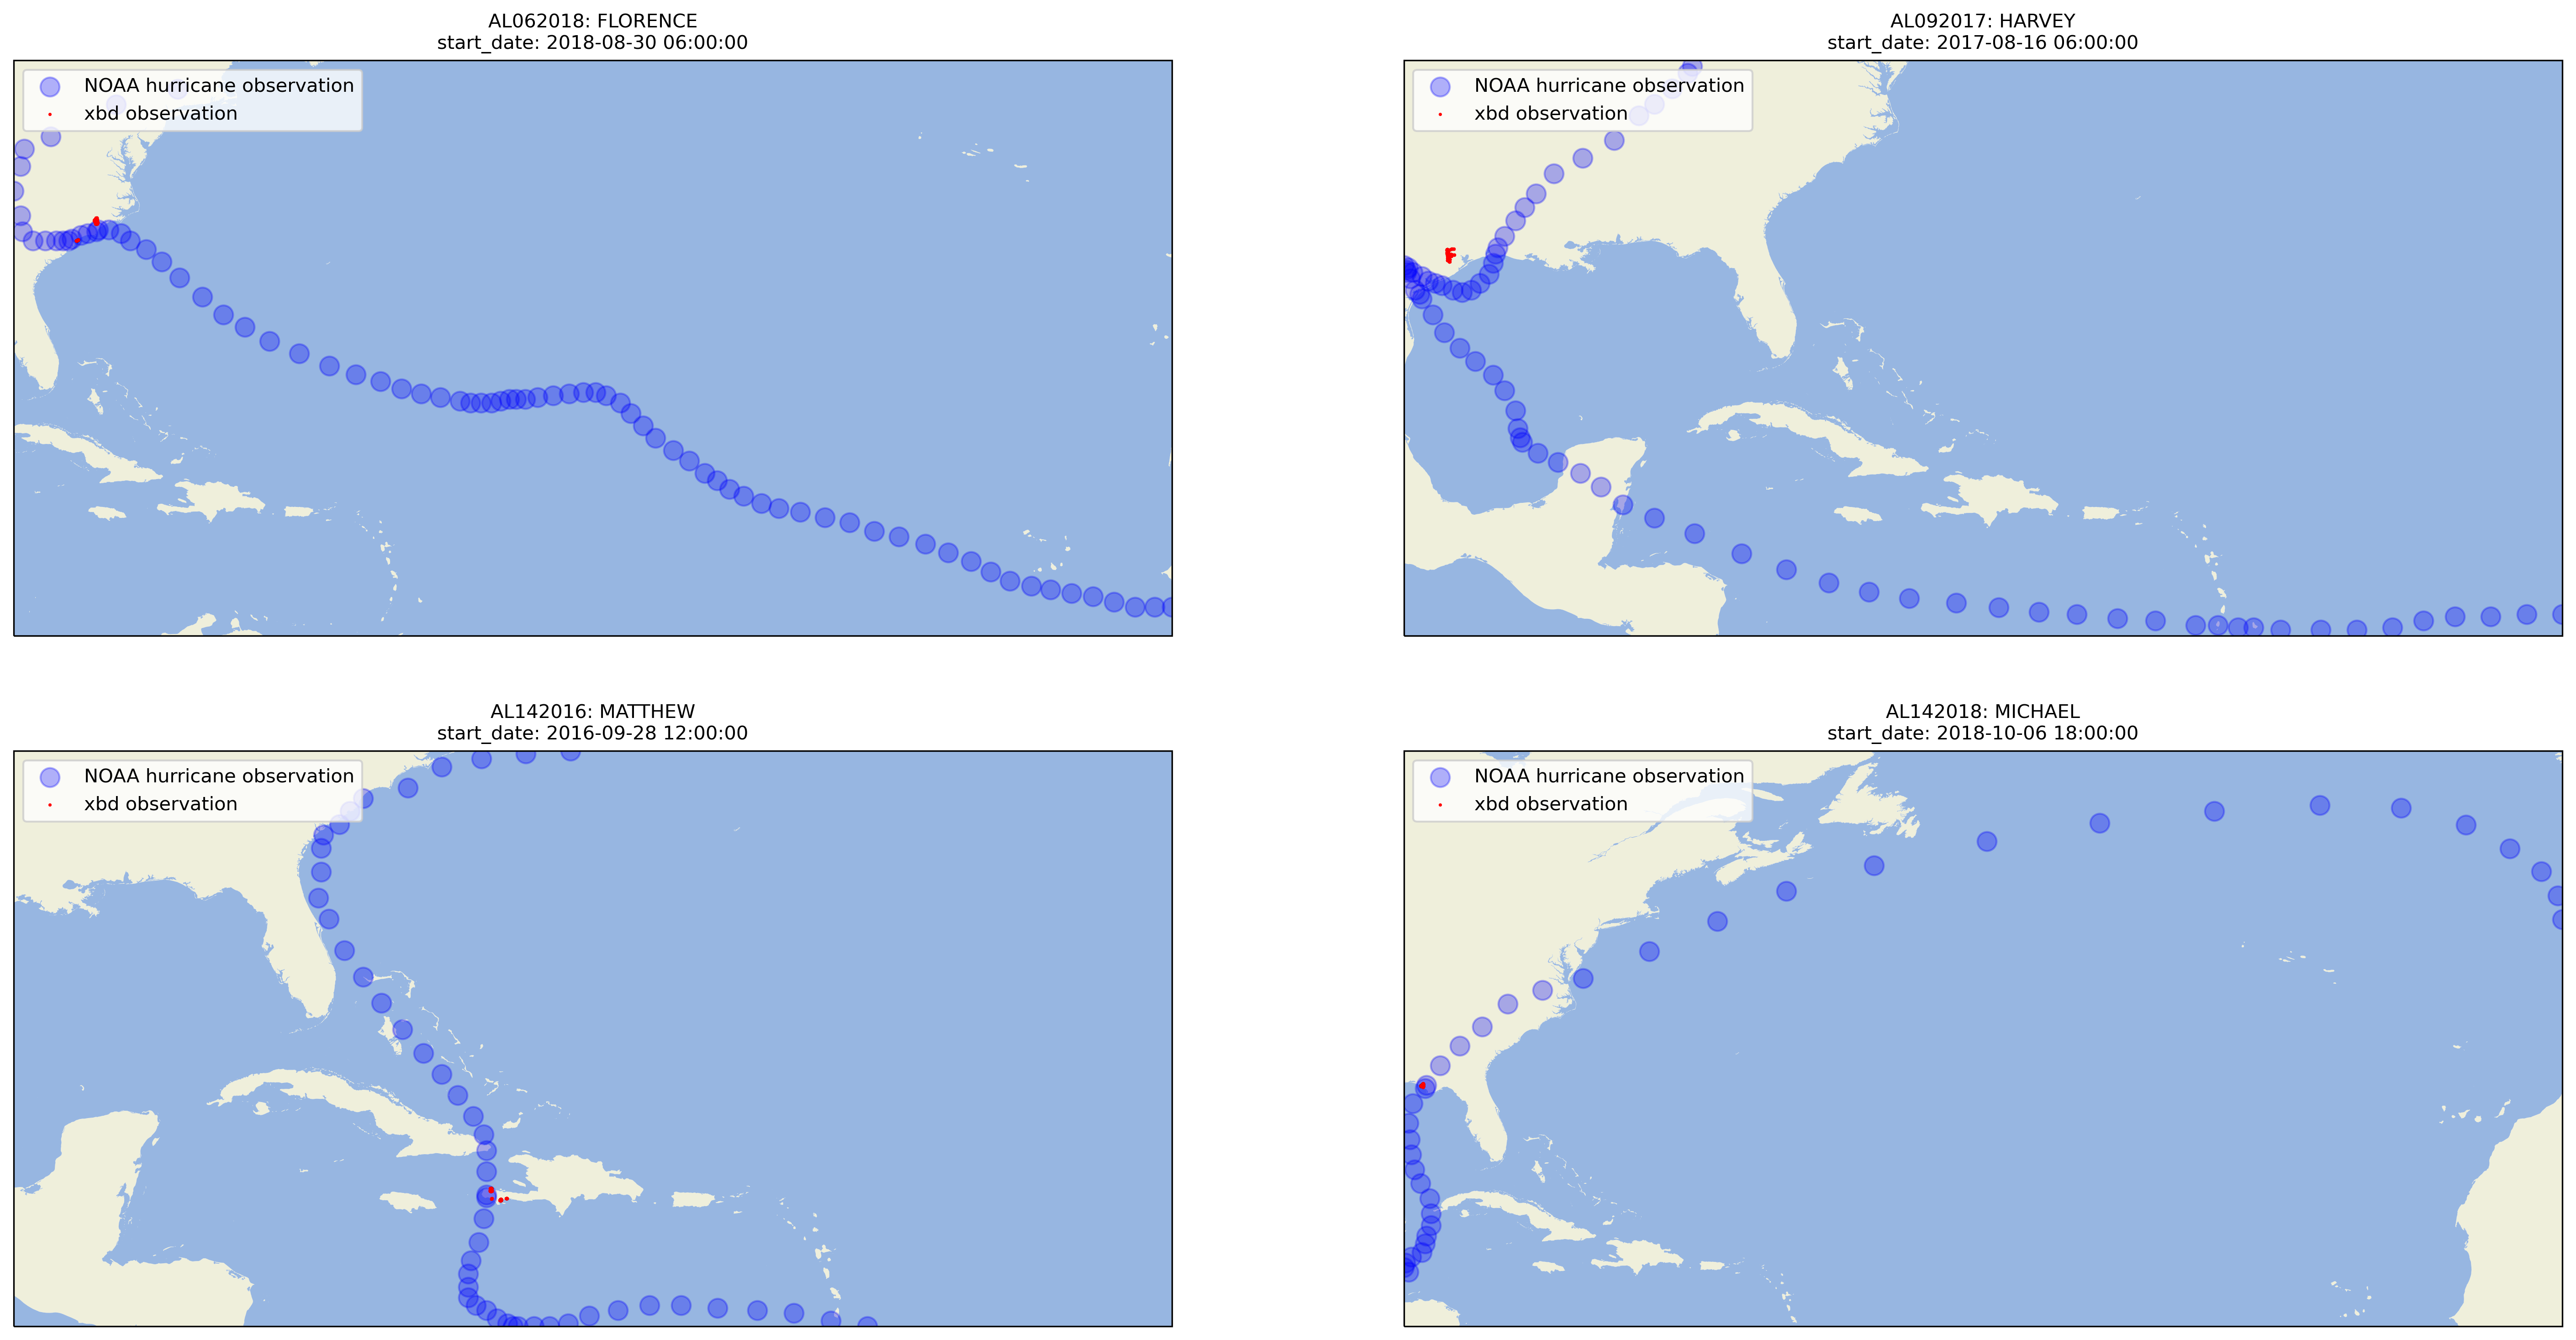

In [ ]:
# plot all xbd hurricane tracks
gtc_functions.plot_hurricane_event_tracks(df_xbd_hurricanes_noaa, gdf_coastlines, df_xbd_points)

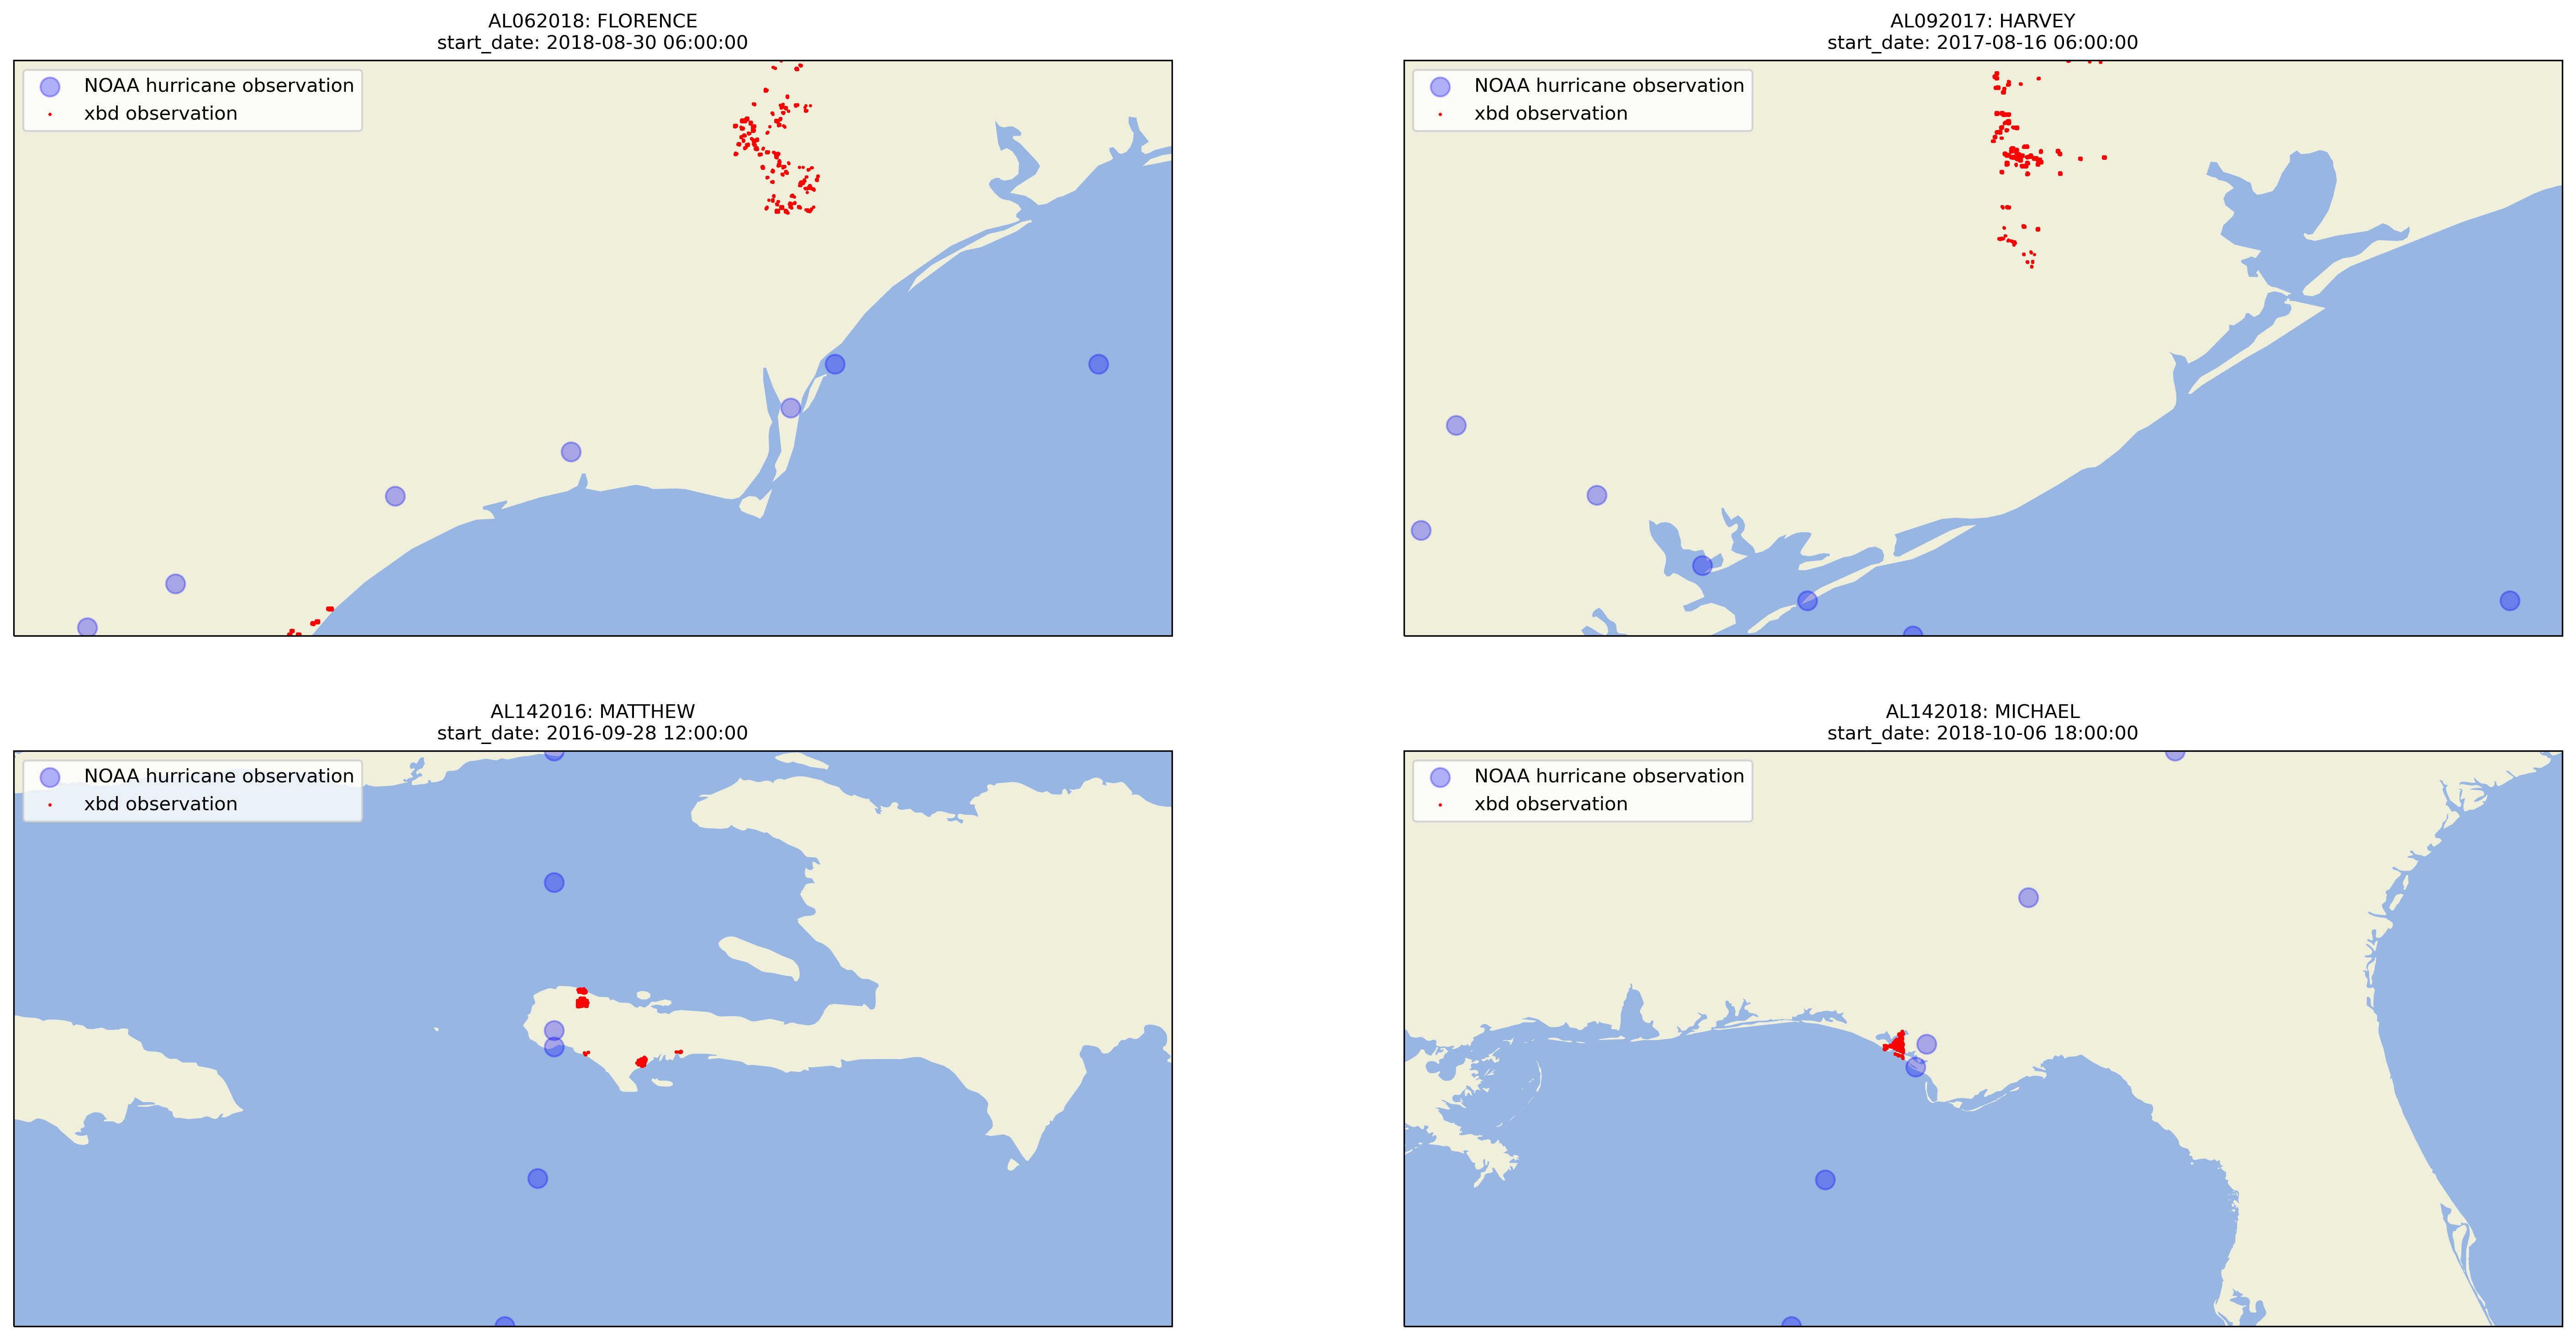

In [ ]:
# plot all xbd hurricane tracks
gtc_functions.plot_hurricane_event_tracks(df_xbd_hurricanes_noaa, gdf_coastlines, df_xbd_points, min_number_weather=5)

In [ ]:
# show event info key to xbd point
event_info = gtc_functions.return_relevant_event_info(df_xbd_points, df_xbd_hurricanes_noaa, 2.5, verbose=True)

event_name: FLORENCE
min_date: 2018-09-14 12:00:00, max_date: 2018-09-15 00:00:00, event_area: [37.0, -80.0, 31.0, -76.0]
event_name: HARVEY
min_date: 2017-08-28 00:00:00, max_date: 2017-08-28 12:00:00, event_area: [33.0, -98.0, 27.0, -94.0]
event_name: MATTHEW
min_date: 2016-10-04 06:00:00, max_date: 2016-10-04 12:00:00, event_area: [21.0, -76.0, 15.0, -72.0]
event_name: MICHAEL
min_date: 2018-10-10 12:00:00, max_date: 2018-10-10 18:00:00, event_area: [33.0, -88.0, 27.0, -84.0]


# Visualise distributions of NOAA parameters

/Users/orlandotimmerman/opt/miniconda3/envs/gtc_code/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Users/orlandotimmerman/opt/miniconda3/envs/gtc_code/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


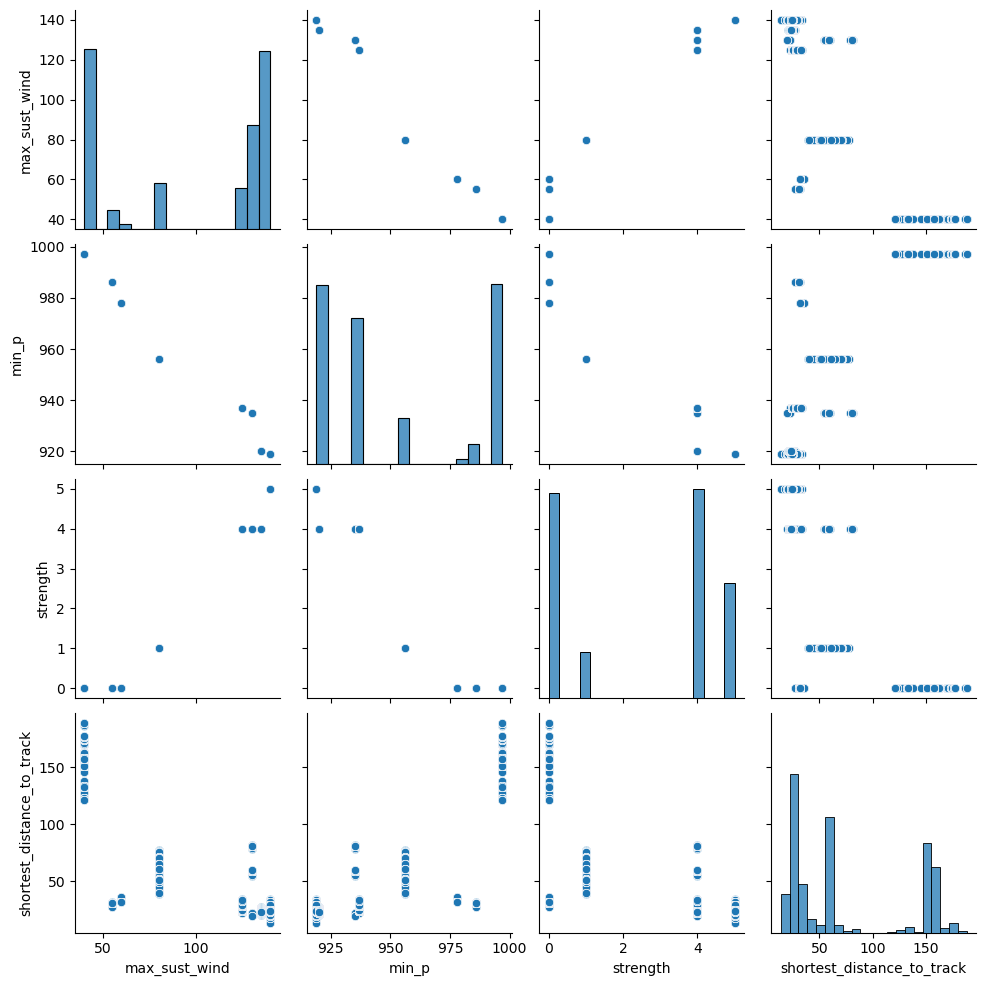

In [ ]:
# greatest feature importance for EFs model
noaa_main_parameters = ['max_sust_wind', 'min_p', 'strength', 'shortest_distance_to_track','name']
sns.pairplot(df_noaa_xbd_weather[noaa_main_parameters]);

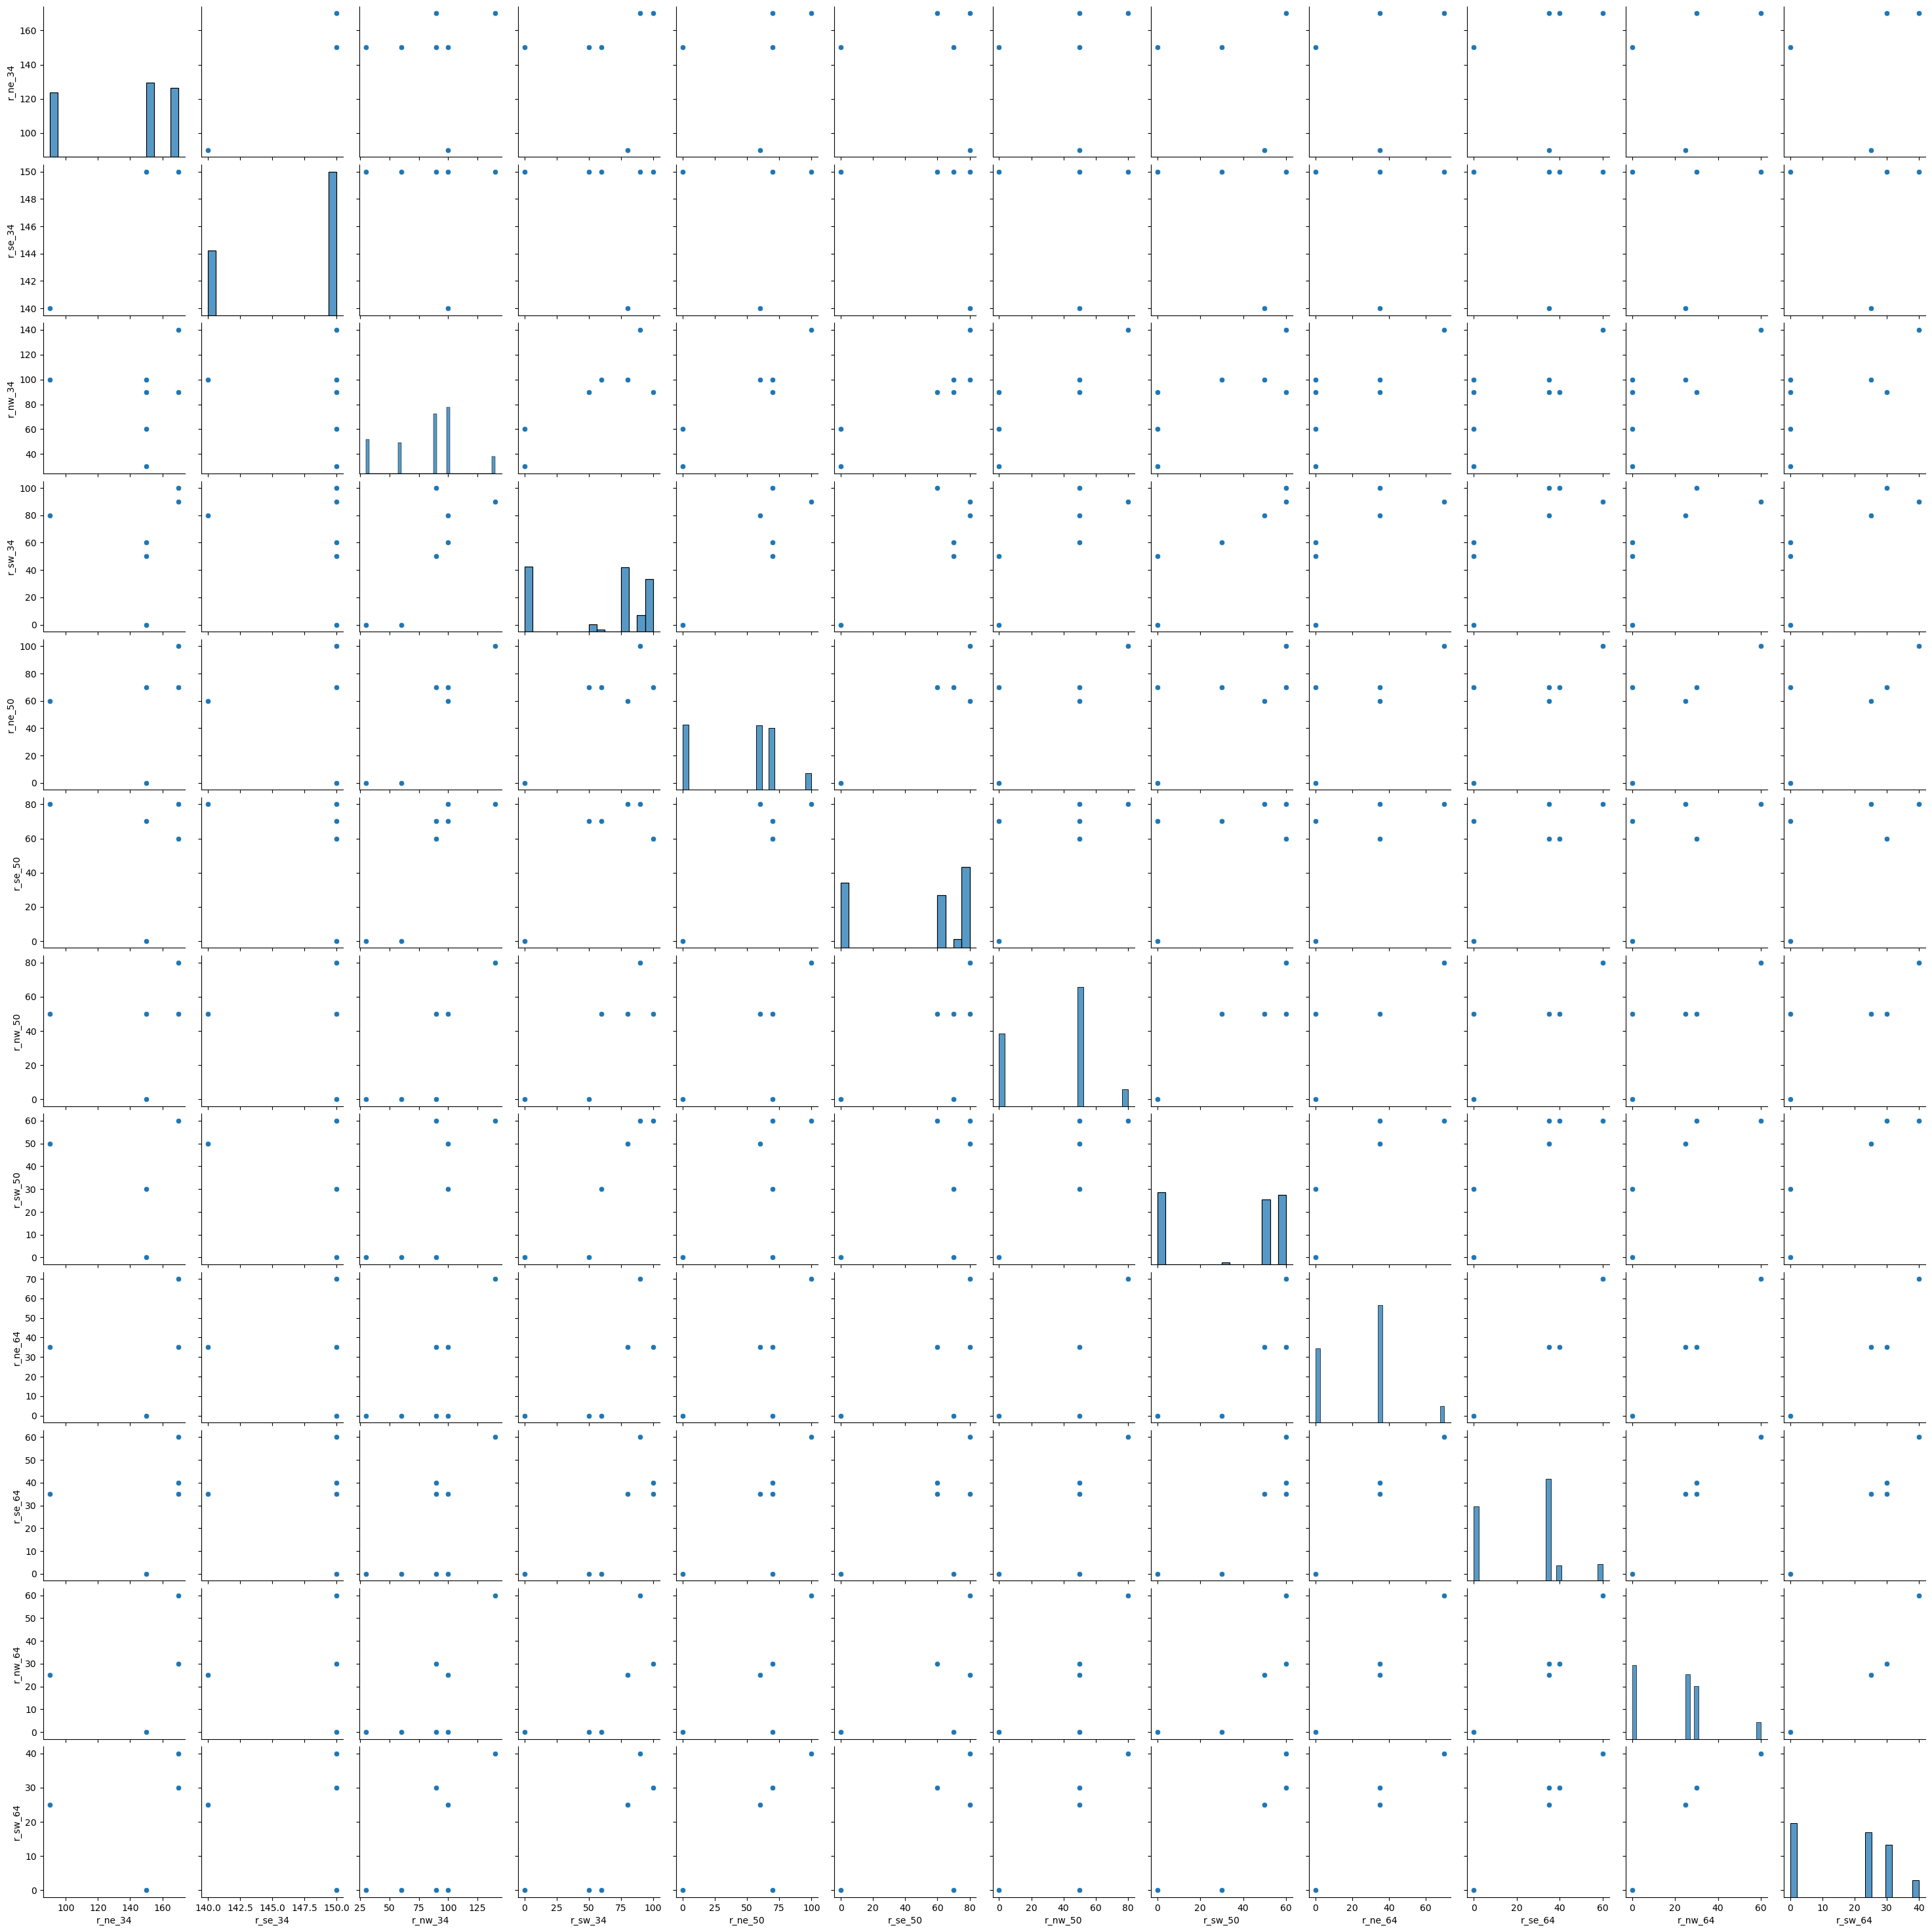

In [ ]:
# considered secondary since lower model importance, and more abstract in literature (not mentioned)
noaa_secondary_parameters = ['r_ne_34', 'r_se_34','r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50', 'r_sw_50', 
       'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64']

# WARNING – takes a long time to generate
sns.pairplot(df_noaa_xbd_weather[noaa_secondary_parameters]);

N.B. notice the very sparse range of values taken by the NOAA weather data points

In [ ]:
# apart from these dropped columns (all nans), there are no nans in df
df_noaa_xbd_weather.drop(['r_max_wind','stations_lat_lons'],axis=1).isna().sum().value_counts()

0    35
dtype: int64

# Visualise data from weather stations

### Weather stations data availability

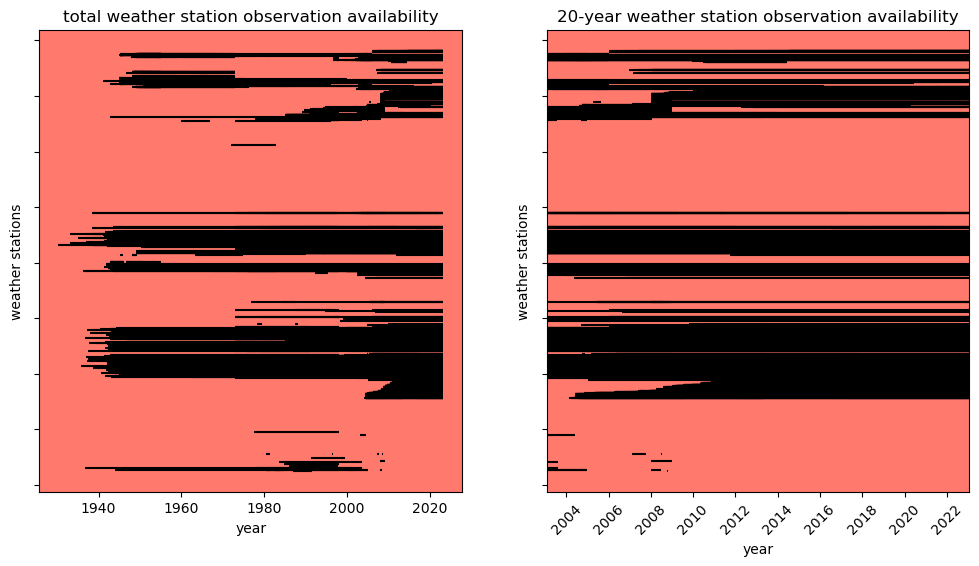

In [ ]:
# set number of stations to include (helps visualise data availability): -1 = all
num_stations = -1

fig, axs = plt.subplots(1,2,figsize=[12,6]);
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].set_xlabel('year'), axs[i].set_ylabel('weather stations')
    axs[i].hlines(df_stations.index[:num_stations], 
        df_stations.begin[:num_stations], df_stations.end[:num_stations],
    color='k')

    # formatting
    axs[i].set_facecolor('xkcd:salmon')
    axs[i].set_yticklabels([])

axs[0].set_title('total weather station observation availability');

axs[1].set_xlim((max(df_stations.end[:num_stations])-pd.Timedelta(20*365,'d')),max(df_stations.end[:num_stations]));
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_title('20-year weather station observation availability');

### Plot geographical distribution of weather stations

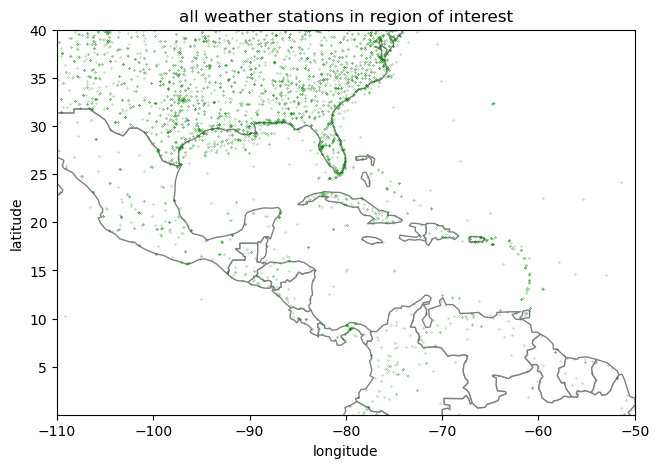

In [ ]:
gdf_stations = gpd.GeoDataFrame(df_stations,geometry=gpd.points_from_xy(df_stations.lon,df_stations.lat))

# fetch worldmap and format plot size
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
plt.rcParams['figure.figsize'] = [13, 7]

fig, ax = plt.subplots(figsize=[12,5]);
ax.set_xlabel('longitude'), ax.set_ylabel('latitude')
world.plot(ax=ax,color='white',edgecolor='grey')
gdf_stations.plot(ax=ax,color='green',markersize=0.05,alpha=0.8);

# formatting
ax.set_xlim([min(gdf_stations['lon']),max(gdf_stations['lon'])]);
ax.set_ylim([min(gdf_stations['lat']),max(gdf_stations['lat'])]);
ax.set_title('all weather stations in region of interest');


### Superimpose hurricane tracks and weather stations, investigating local weather station availability

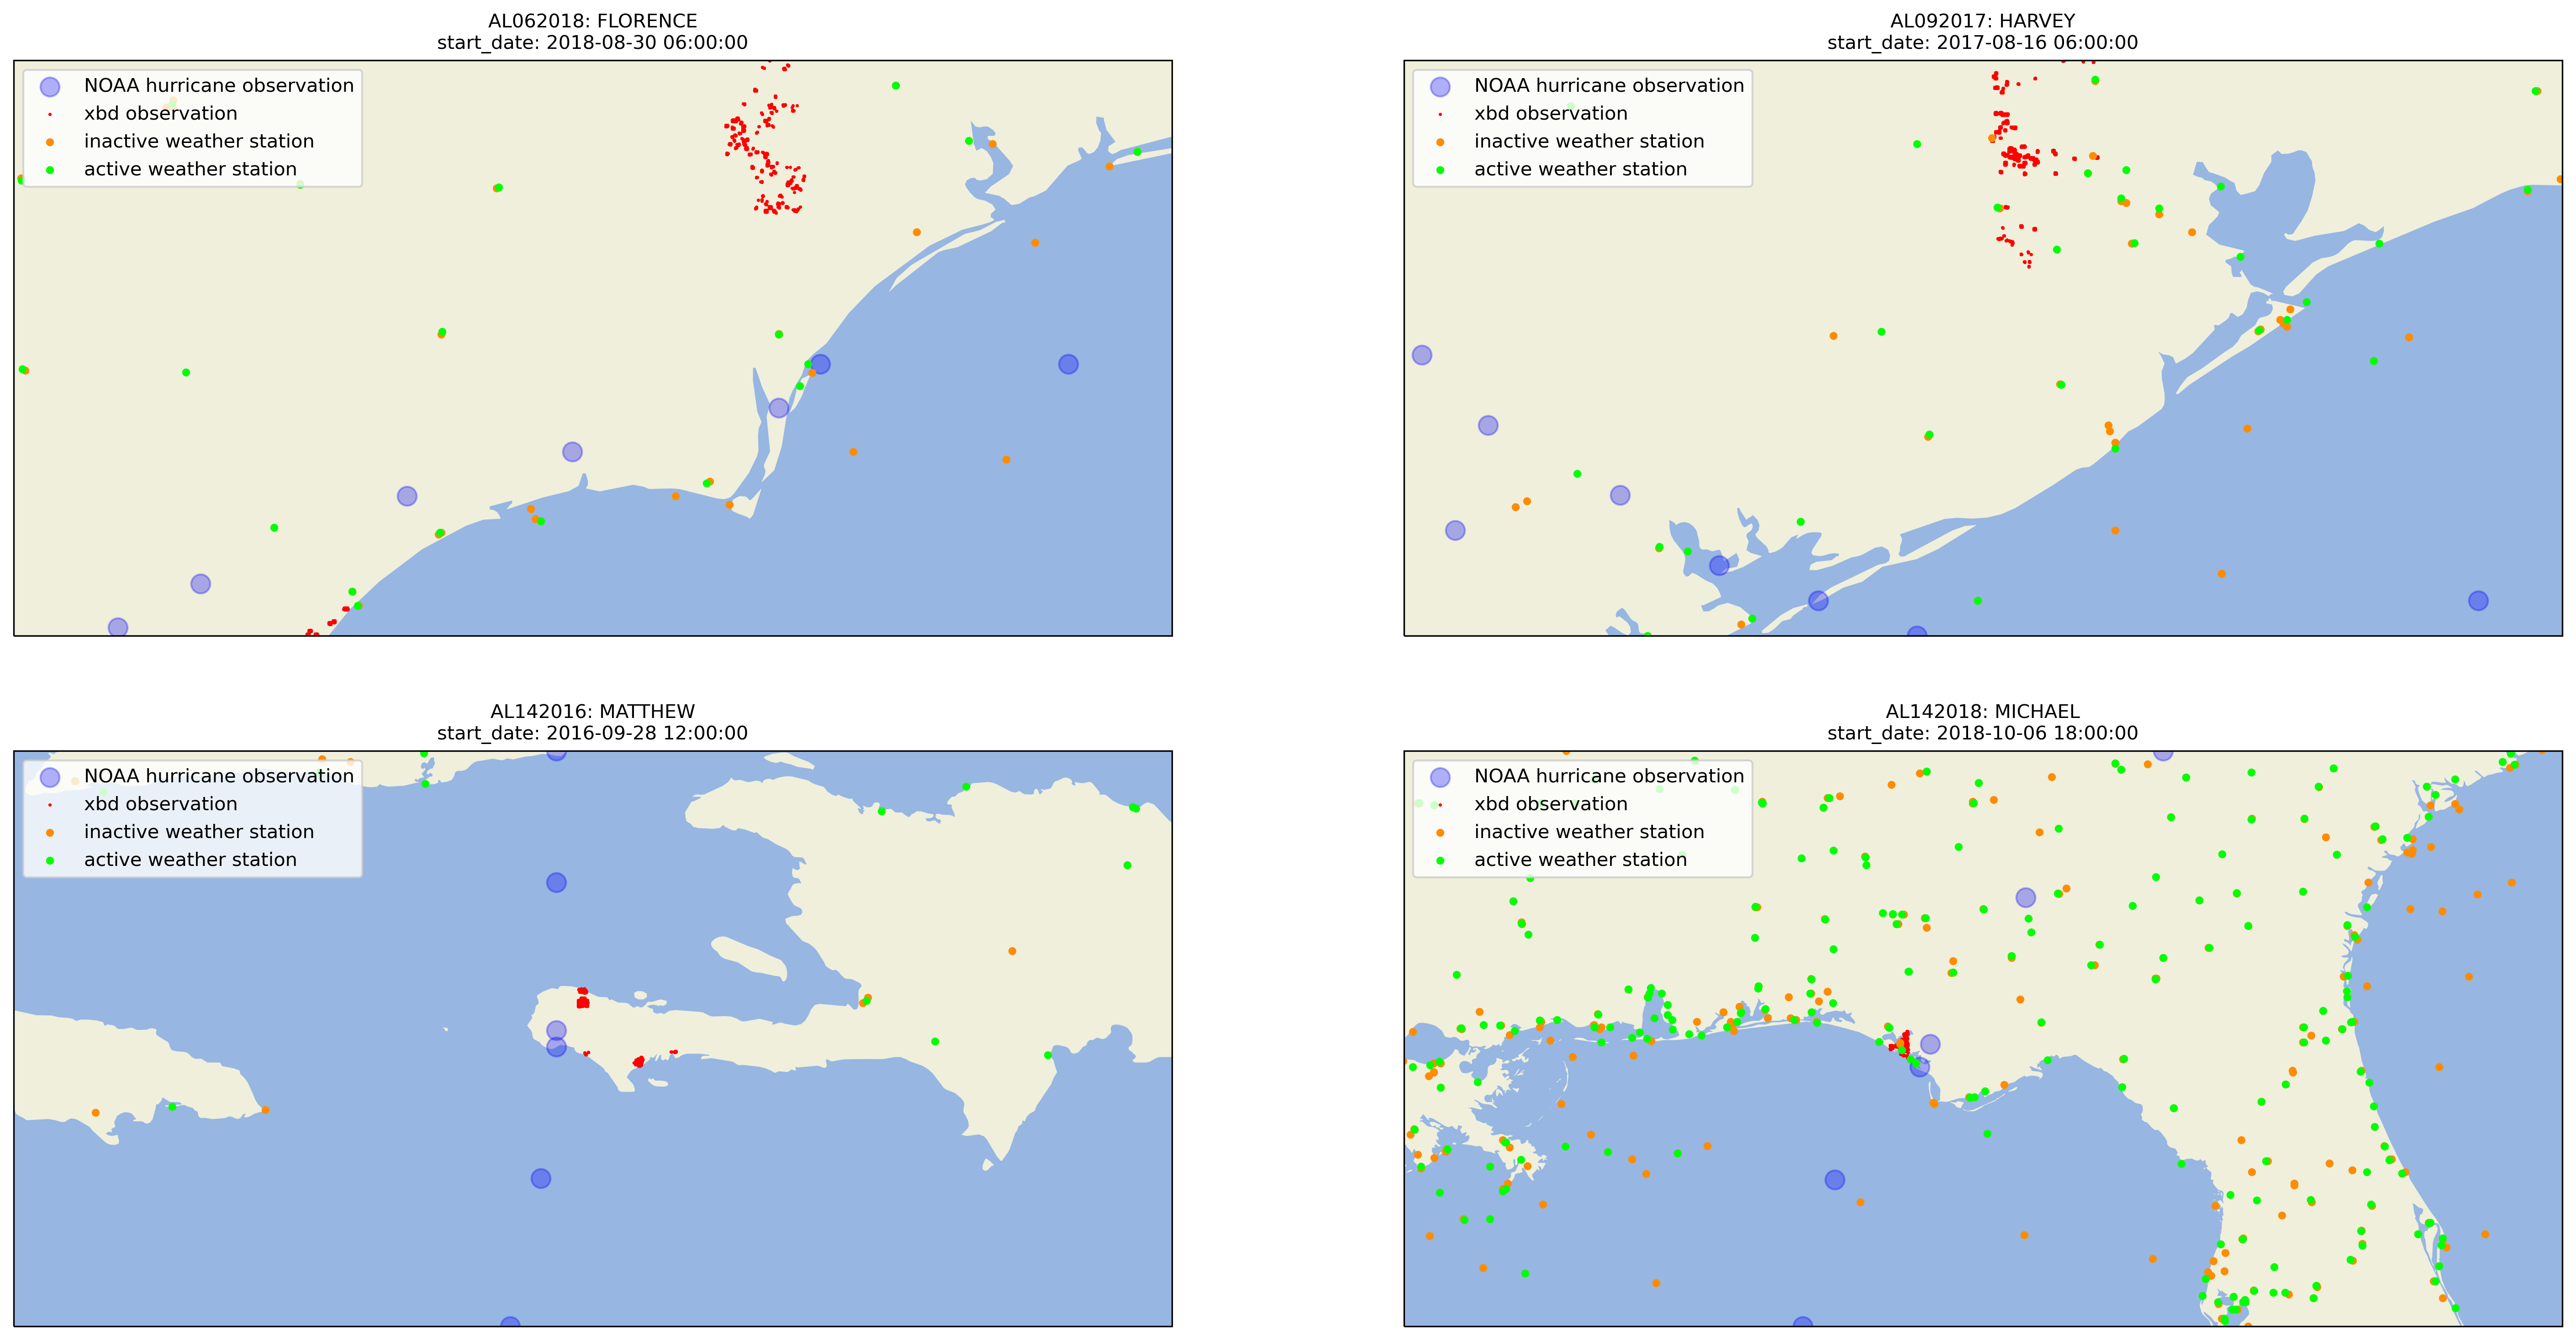

In [ ]:
# plot active and inactive stations relative to xbd points and hurricane tracks
gtc_functions.plot_hurricane_event_tracks(df_xbd_hurricanes_noaa, gdf_coastlines, df_xbd_points, 
	df_stations=df_stations, min_number_weather=5)

The poor data seen in the weather stations data raises questions as to the validity of GaLeNet's use of the same data via the OpenWeatherMap API (which uses this weather station data)...

### Compare proximity of NOAA observations and weather station observations relative to xBD points

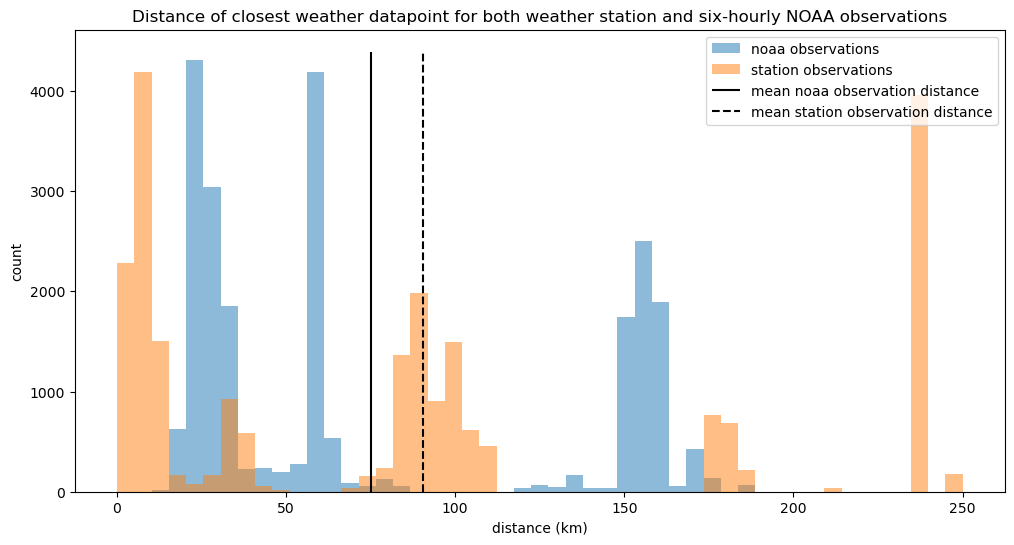

In [ ]:
# compare distances between NOAA observations and weather station observations
# relative to xbd points

# calculate average distances
av_noaa_xbd_distance = df_noaa_xbd_weather['shortest_distance_to_track'].mean()
av_station_distance = df_stations_xbd['distance_to_closest'].mean()

fig,ax_hist = plt.subplots(figsize=[12,6])

# plot histogram
bins = np.linspace(0,250,50)
n_noaa,_,_ = ax_hist.hist(df_noaa_xbd_weather['shortest_distance_to_track'],bins,alpha=0.5,label='noaa observations');
n_stations,_,_ = ax_hist.hist(df_stations_xbd['distance_to_closest'],bins,alpha=0.5,label='station observations');

# plot means
ax_hist.vlines(av_noaa_xbd_distance,ymin=0,ymax=np.max(n_noaa+n_stations),color='k',label='mean noaa observation distance')
ax_hist.vlines(av_station_distance,ymin=0,ymax=np.max(n_noaa+n_stations),color='k',ls='--',label='mean station observation distance')

# formatting
ax_hist.set_title('Distance of closest weather datapoint for both weather station and six-hourly NOAA observations')
ax_hist.set_xlabel('distance (km)'), ax_hist.set_ylabel('count')
ax_hist.legend(loc='upper right');


The histogram above shows that the weather stations are on average further from the xBD observations than the NOAA observations, even though there is a relatively large number of very close stations. This may well be because for some events (likely Hurricane Matthew in Haiti) had very few nearby stations. This is telling of the inequality of infrastructure between the US and the Caribbean islands. Yet another reason to use geography-agnostic ECMWF data.

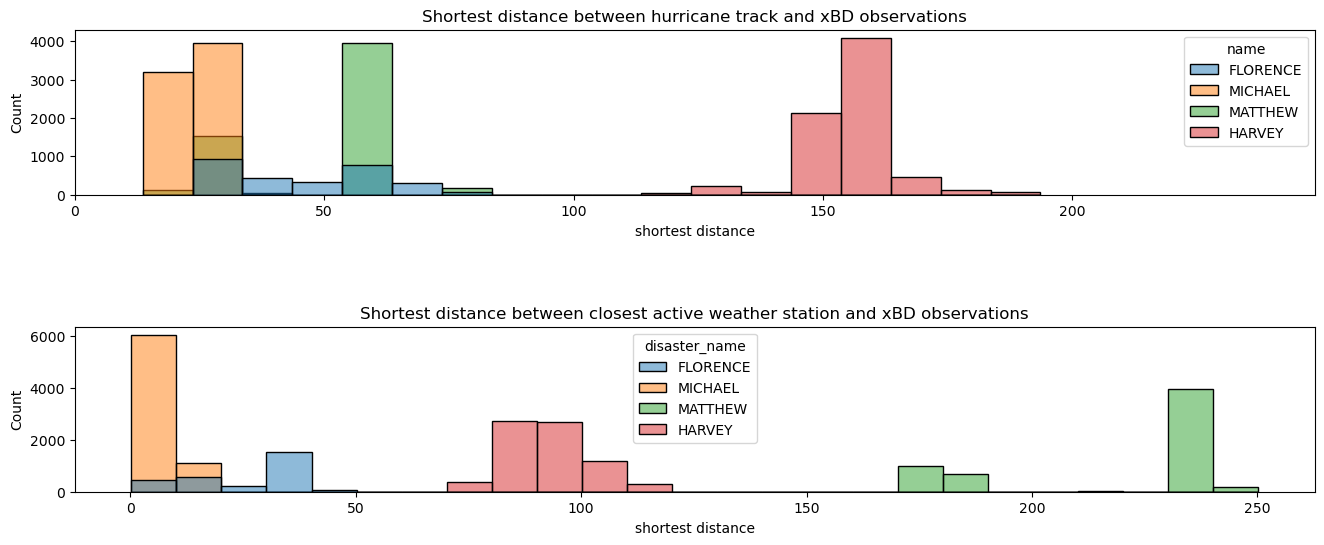

In [ ]:
fig,(ax_noaa,ax_station) = plt.subplots(2, 1, figsize=[16,6])

# TODO: put into script more efficiently, add on average vlines
sns.histplot(ax=ax_noaa,data=df_noaa_xbd_weather,x='shortest_distance_to_track',hue='name',binwidth=10);
sns.histplot(ax=ax_station,data=df_stations_xbd,x='distance_to_closest',hue='disaster_name',binwidth=10);

ax_noaa.set_title('Shortest distance between hurricane track and xBD observations')
ax_noaa.set_xlabel('shortest distance')
ax_station.set_title('Shortest distance between closest active weather station and xBD observations')
ax_station.set_xlabel('shortest distance')

xs = df_noaa_xbd_weather['shortest_distance_to_track'].tolist() + df_stations_xbd['distance_to_closest'].tolist()
ax_noaa.set_xlim(xmin=0,xmax=max(xs))

fig.subplots_adjust(hspace=0.8)

# Investigate ECMWF Data

In [ ]:
# Load data for each hurricane
# plot feature distributions for each event
# potentially combine feature distributions



The ECMWF weather data is at a consistent 0.1 degree resolution for all geographical regions. Using this avoids the varying proximity of weather stations to the xBD datapoints seen above, and bypasses the data interpolation steps necessary to get the weather station data into a workable format. 